### Predicción de ETo con un dataset generado

In [156]:
import pandas as pd
import numpy as np
from eto import ETo
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, LSTM, Bidirectional, Attention, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [157]:
df = pd.read_csv('custom_weather_data.csv', index_col=['Date'], parse_dates=True) # Necesario parse_dates para que el indice sea tipo datetime
df.head()

,Solar Radiation (W/m²),Heat Flux Density (W/m²),Mean Temperature (°C),Vapor Pressure Slope (kPa/ºC),Wind Speed (m/s),T_min,T_max
Date,,,,,,,
2023-01-01,384.987706,228.234406,25.320376,0.952271,9.276121,21.204441,27.827692
2023-01-02,435.759804,278.652402,26.446891,1.004507,6.206753,19.667378,28.572243
2023-01-03,443.778788,260.028145,28.814782,1.049978,5.695680,27.047165,35.596402
2023-01-04,396.162356,247.336488,21.838875,0.851710,3.409369,20.112822,26.648638
2023-01-05,408.274535,243.737733,26.264700,0.987383,2.279993,20.979772,31.902069


#### Paso 1: Aplicamos las funciones de la librería **eto**  
**``param_est``**: Indica si hay suficientes datos y, si es así, estima los que falten  
**``eto_fao``**: Calcula la ETo

In [158]:
# Establecer los valores geográficos para Salamanca
z_msl = 800 # Altitud de la estación de medición sobre el nivel del mar (metros)
lat = 40.97 # Latitud (grados)
lon = -5.66 # Longitud (grados)
freq = 'D' # Frecuencia para la medición (min horas (H) y max meses (M))

# Instanciar objeto ETo
et1 = ETo()

# Aplicar param_est que devuelve un df con los valores necesarios estimados para calcular la ETo
et1.param_est(df, freq, z_msl, lat, lon)
et1.ts_param.head()

,Solar Radiation (W/m²),Heat Flux Density (W/m²),Mean Temperature (°C),Vapor Pressure Slope (kPa/ºC),Wind Speed (m/s),T_min,T_max,R_n,R_s,G,T_mean,T_dew,RH_min,RH_max,RH_mean,n_sun,U_z,P,e_a,gamma,e_max,e_min,e_s,delta,R_a,U_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01,384.987706,228.234406,25.320376,0.952271,9.276121,21.204441,27.827692,2.489857,5.448522,0.0,24.516067,NaN,NaN,NaN,NaN,NaN,NaN,92.19414,2.518408,0.061309,3.742172,2.518408,3.130290,0.183989,13.231928,2.0
2023-01-02,435.759804,278.652402,26.446891,1.004507,6.206753,19.667378,28.572243,2.470667,6.344218,0.0,24.119811,NaN,NaN,NaN,NaN,NaN,NaN,92.19414,2.290567,0.061309,3.907717,2.290567,3.099142,0.180220,13.287536,2.0
2023-01-03,443.778788,260.028145,28.814782,1.049978,5.695680,27.047165,35.596402,3.300997,6.244359,0.0,31.321783,NaN,NaN,NaN,NaN,NaN,NaN,92.19414,3.575217,0.061309,5.810695,3.575217,4.692956,0.259856,13.347630,2.0
2023-01-04,396.162356,247.336488,21.838875,0.851710,3.409369,20.112822,26.648638,2.462880,5.486178,0.0,23.380730,NaN,NaN,NaN,NaN,NaN,NaN,92.19414,2.354662,0.061309,3.492503,2.354662,2.923582,0.173364,13.412199,2.0
2023-01-05,408.274535,243.737733,26.264700,0.987383,2.279993,20.979772,31.902069,2.739865,7.128638,0.0,26.440921,NaN,NaN,NaN,NaN,NaN,NaN,92.19414,2.483917,0.061309,4.728526,2.483917,3.606221,0.203256,13.481232,2.0


In [159]:
# Cálculo de la ETo
eto1 = et1.eto_fao()

# Convertir la Serie en un Dataframe
def serie_to_dataframe(serie, col1_name, col2_name):
    serie = serie.reset_index()
    serie.columns = [col1_name, col2_name]
    return serie

eto1 = serie_to_dataframe(eto1, 'Date', 'ETo')
eto1.head()

,Date,ETo
0,2023-01-01,1.44
1,2023-01-02,1.70
2,2023-01-03,2.08
3,2023-01-04,1.40
4,2023-01-05,2.09


In [160]:
# Añadir la ETo calculada para cada fecha
df = pd.merge(df, eto1, left_index=True, right_on='Date')
df.set_index("Date", inplace=True)
df.index = pd.to_datetime(df.index)
df

,Solar Radiation (W/m²),Heat Flux Density (W/m²),Mean Temperature (°C),Vapor Pressure Slope (kPa/ºC),Wind Speed (m/s),T_min,T_max,ETo
Date,,,,,,,,
2023-01-01,384.987706,228.234406,25.320376,0.952271,9.276121,21.204441,27.827692,1.44
2023-01-02,435.759804,278.652402,26.446891,1.004507,6.206753,19.667378,28.572243,1.70
2023-01-03,443.778788,260.028145,28.814782,1.049978,5.695680,27.047165,35.596402,2.08
2023-01-04,396.162356,247.336488,21.838875,0.851710,3.409369,20.112822,26.648638,1.40
2023-01-05,408.274535,243.737733,26.264700,0.987383,2.279993,20.979772,31.902069,2.09
...,...,...,...,...,...,...,...,...
2025-09-22,400.212834,241.387236,23.614501,0.901570,5.793780,21.672403,30.465031,3.22
2025-09-23,354.462393,206.505274,23.263684,0.891987,6.971197,19.406041,26.051675,2.51
2025-09-24,378.712282,232.502462,26.524220,0.995561,7.957566,19.547760,32.999992,4.05


#### Paso 2: Preprocesar los datos

In [161]:
# Asegurar reproducibilidad
tf.random.set_seed(27)

In [162]:
def secuencias(df, features, target, lookback):
    X, y = [], []
    for i in range(len(df) - lookback):
        X.append(df[features].iloc[i:i+lookback].values) # Recoge los features dejando fueras los n señalados como lookback
        y.append(df[target].iloc[i+lookback]) # Para cada paso temporal guarda n lookback como target
    return np.array(X), np.array(y)

In [163]:
# Establecer la longitud de los datos para entrenamiento
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

# Establecer features y target
features = ['Solar Radiation (W/m²)', 
            'Heat Flux Density (W/m²)',
            'Mean Temperature (°C)',
            'Vapor Pressure Slope (kPa/ºC)',
            'Wind Speed (m/s)',
            'T_min', 'T_max']
target = 'ETo'

# Estandarizar datos
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

# Crear los conjuntos separados X e y para entrenamiento y validación
X_train, y_train = secuencias(train, features, target, lookback=1)
X_test, y_test = secuencias(test, features, target, lookback=1)

In [164]:
print('Forma del dataset de entrenamiento')
print(f'Filas: {X_train.shape[0]}\t Pasos temporales: {X_train.shape[1]}\t Atributos: {X_train.shape[2]}')

Forma del dataset de entrenamiento
Filas: 699	 Pasos temporales: 1	 Atributos: 7


#### Paso 3: Creación del modelo

In [165]:
# Capa de entrada, recibe pasos temporales y atributos
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Capa bidireccional LSTM, con retorno de secuencias
lstm1 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(input_layer)
lstm2 = LSTM(256, return_sequences=True, dropout=0.3)(lstm1)
lstm3 = LSTM(128, return_sequences=True, dropout=0.3)(lstm2)

# Capa atencional. Recibe dos valores (query y key-value) con shape: batch_size, time_steps, features
# Calcula los pesos entre el query y las keys para ponderar los values
att = Attention()([lstm3, lstm3])

# Context vector, representación numérica de la secuencia tras la capa de atención
ctx_vector = Flatten()(att)

# Capas densas
x = Dense(128, activation='relu')(ctx_vector)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='linear')(x)

# Construir y compilar
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 1, 1024)   │  2,129,920 │ input_layer_10[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 1, 256)    │  1,311,744 │ bidirectional_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 1, 128)    │    197,120 │ lstm_24[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_9         │ (None, 1, 128)    │          0 │ lstm_25[0][0],    │
│ (Attention)         │                   │            │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 128)       │          0 │ attention_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 128)       │     16,512 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      8,256 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 32)        │      2,080 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32)        │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 16)        │        528 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 16)        │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │         17 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,666,177 (13.99 MB)

 Trainable params: 3,666,177 (13.99 MB)

 Non-trainable params: 0 (0.00 B)

In [166]:
# Crear un early stopper
early_stop = EarlyStopping(
    monitor='val_loss', # Pérdida en validación como referencia
    patience=10, # Detiene el entrenamiento si no hay mejoras tras 7 rondas
    restore_best_weights=True # Recupera los mejores pesos obtenidos
)

In [167]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=50,
          batch_size=16,
          callbacks=[early_stop])

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 10.0927 - mae: 2.8314 - val_loss: 2.3986 - val_mae: 1.1923
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.2269 - mae: 1.4009 - val_loss: 1.7552 - val_mae: 1.0231
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.9659 - mae: 1.3355 - val_loss: 1.5958 - val_mae: 0.9463
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.5358 - mae: 1.2053 - val_loss: 2.0551 - val_mae: 1.1002
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.3953 - mae: 1.1790 - val_loss: 1.2533 - val_mae: 0.8264
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.4258 - mae: 1.1918 - val_loss: 1.4139 - val_mae: 0.8825
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.9991 - mae: 1.0681 - val_loss: 1.4818 - val_mae: 0.8898
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.0225 - mae: 1.1120 - val_loss: 1.8014 - val_mae: 1.0043
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.81

In [168]:
valid_error = model.evaluate(X_test, y_test)

print(f'Mean Squared Error: {valid_error[0]:.2f}')
print(f'Mean Absolute Error: {valid_error[1]:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6451 - mae: 0.5433
Mean Squared Error: 0.92
Mean Absolute Error: 0.70


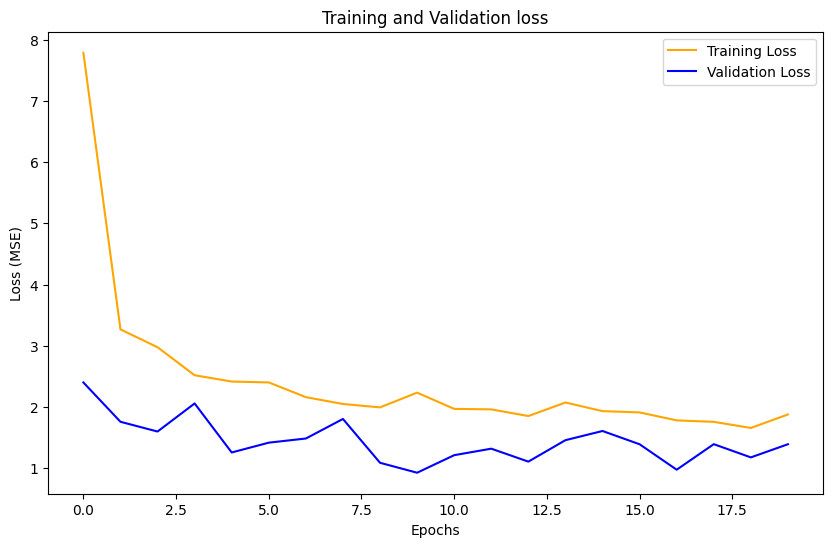

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
plt.show()

In [170]:
y_pred = model.predict(X_test)
print(y_pred[0])

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
[1.4574385]


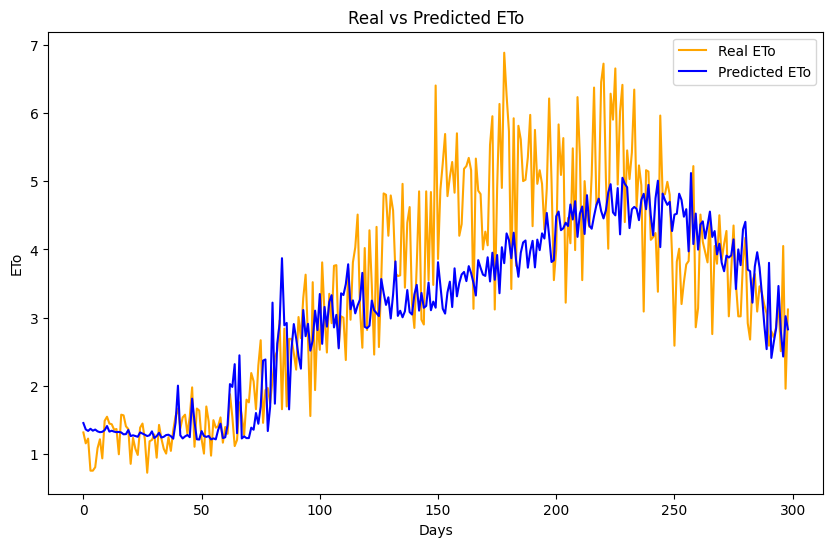

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Real ETo', color='orange')
plt.plot(y_pred, label='Predicted ETo', color='blue')

plt.title('Real vs Predicted ETo')
plt.xlabel('Days')
plt.ylabel('ETo')
plt.legend()
plt.show()